# Topic modelling
## Importing data
This dataset consist of speach given by different presidents of united states of america from 1709 to 2022.

In [11]:
import pandas as pd
file = "C:/Users/anjal/Downloads/archive (3)/songs.csv"
df = pd.read_csv(file)
df.head(10)

Name             Artist  \
0                 Imagine - Remastered 2010        John Lennon   
1                    A Whiter Shade Of Pale       Procol Harum   
2                             My Sweet Lord    George Harrison   
3                     God Only Knows - Mono     The Beach Boys   
4                Bridge Over Troubled Water  Simon & Garfunkel   
5       Bohemian Rhapsody - Remastered 2011              Queen   
6             Stairway to Heaven - Remaster       Led Zeppelin   
7                  All Along the Watchtower       Jimi Hendrix   
8          Hotel California - 2013 Remaster             Eagles   
9  “Heroes” - Single Version; 2014 Remaster        David Bowie   

                                           Album  Popularity  \
0                                        Imagine          79   
1                         A Whiter Shade Of Pale           0   
2              All Things Must Pass (Remastered)           0   
3        Pet Sounds (Original Mono & Stereo Mix)          67   
4                     Bridge Over Troubled Water          72   
5           A Night At The Opera (2011 Remaster)           0   
6               Led Zeppelin IV (Deluxe Edition)          80   
7                              Electric Ladyland          77   
8               Hotel California (2013 Remaster)          85   
9  Legacy (The Very Best Of David Bowie, Deluxe)          17   

                                              Lyrics  
0  8 ContributorsDiscographie 2021 — Pop & Rock L...  
1  38 ContributorsA Whiter Shade of Pale Lyrics[I...  
2  58 ContributorsMy Sweet Lord Lyrics[Chorus]\nM...  
3  1 ContributorGod Only Knows (mono mix) LyricsI...  
4  57 ContributorsBridge Over Troubled Water Lyri...  
5  1 ContributorTop Groups of 2021 LyricsBTS - Bu...  
6  1 ContributorSasquatch LyricsCall me Tony Hawk...  
7  107 ContributorsAll Along the Watchtower Lyric...  
8  1 ContributorEagles - Hotel California (2013 R...  
9  3 ContributorsIrrelevant Cabbage’s Ever-Growin...

In [12]:
print(repr(df.iloc[10]["Lyrics"][0:400]))
print(repr(df.iloc[60]["Lyrics"][0:400]))

"30 ContributorsIn the Ghetto Lyrics[Verse 1]\nAs the snow flies\nOn a cold and gray Chicago mornin'\nA poor little baby child is born\nIn the ghetto (In the ghetto)\nAnd his mama cries\n'Cause if there's one thing that she don't need\nIt's another hungry mouth to feed\nIn the ghetto (In the ghetto)\n\n[Bridge]\nPeople, don't you understand\nA child needs a helping hand\nOr he'll grow to be an angry young man s"
"38 ContributorsJust Like a Woman Lyrics[Verse 1]\nNobody feels any pain\nTonight as I stand inside the rain\nEverybody knows that baby's got new clothes\nBut lately I see her ribbons and her bows\nHave fallen from her curls\n\n[Chorus]\nShe takes just like a woman, yeah she does\nShe makes love just like a woman, yeah she does\nAnd she aches just like a woman\nBut she breaks just like a little girl\n\n[Verse 2"


In [13]:
df.isna().sum()

Name          0
Artist        0
Album         0
Popularity    0
Lyrics        0
dtype: int64

## Splitting speech into sentence

In [14]:
import re
df["paragraphs"] = df["Lyrics"].map(lambda text: re.split('\.\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords),min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['Lyrics'])
tfidf_text_vectors.shape

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(799, 7876)

In [16]:
paragraph_df = pd.DataFrame([{ "text": paragraph, "Popularity": year }
                             for paragraphs, year in zip(df["paragraphs"], df["Popularity"])
                             for paragraph in paragraphs if paragraph])
paragraph_df.head(10)

text  Popularity
0  8 ContributorsDiscographie 2021 — Pop & Rock L...          79
1  * 30/04 : Frédérick Doiron - J'aurais dû reste...          79
2  — 14/05 : New Bleach - Impressions\n* 14/05 : ...          79
3  * 26/05 : Louis Doré - Chanteur country\n— 28/...          79
4  * 20/08 : Philémon Cimon - L'amour\n* 20/08 : ...          79
5  38 ContributorsA Whiter Shade of Pale Lyrics[I...           0
6  58 ContributorsMy Sweet Lord Lyrics[Chorus]\nM...           0
7  1 ContributorGod Only Knows (mono mix) LyricsI...          67
8  57 ContributorsBridge Over Troubled Water Lyri...          72
9  1 ContributorTop Groups of 2021 LyricsBTS - Bu...           0

## Getting TFIDF of sentences

In [18]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words=list(stopwords),min_df=5, max_df=0.7)
tfidf_para_vectors =tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(4145, 10329)

## NMF

In [19]:
from sklearn.decomposition import NMF
nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

## Getting topics

In [20]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out()) 



Topic 00
  don (0.88)
  know (0.79)
  got (0.72)
  cause (0.67)
  ain (0.63)

Topic 01
  found (62.07)
  finally (0.88)
  right (0.46)
  sunshine (0.46)
  shine (0.46)

Topic 02
  que (5.70)
  te (2.81)
  de (2.01)
  el (1.99)
  lo (1.79)

Topic 03
  feat (3.39)
  eminem (1.15)
  lil (0.45)
  weeknd (0.42)
  ft (0.34)

Topic 04
  da (20.61)
  chemical (1.95)
  giving (1.74)
  hurt (1.08)
  instead (1.05)

Topic 05
  oh (10.48)
  wanna (1.56)
  chorus (1.26)
  know (1.26)
  woah (1.08)

Topic 06
  na (13.16)
  feelin (3.77)
  good (3.76)
  yeah (3.59)
  baby (3.38)

Topic 07
  ooh (12.95)
  ah (4.65)
  baby (1.59)
  yeah (1.58)
  woo (1.07)

Topic 08
  love (7.37)
  baby (3.58)
  better (1.94)
  wanna (1.90)
  chorus (1.69)

Topic 09
  la (10.56)
  aran (2.65)
  sio (2.03)
  cupid (1.68)
  hey (1.60)


In [21]:
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())


Topic 00
  oh (1.66)
  don (1.34)
  chorus (1.31)
  know (1.24)
  like (1.11)

Topic 01
  thou (1.00)
  said (0.95)
  al (0.91)
  king (0.90)
  thee (0.80)

Topic 02
  laurie (11.50)
  dreiberg (7.73)
  jon (1.37)
  adrian (1.10)
  daniel (0.91)

Topic 03
  manhattan (10.51)
  dr (9.96)
  jon (1.67)
  laurie (1.01)
  long (0.90)

Topic 04
  fn (5.87)
  arab (2.02)
  al (1.03)
  koran (0.83)
  mohammed (0.60)

Topic 05
  found (27.77)
  lyrics (19.08)
  syrians (0.86)
  finally (0.40)
  vent (0.35)

Topic 06
  rorschach (8.88)
  veidt (2.53)
  dreiberg (1.28)
  cont (1.06)
  long (0.95)

Topic 07
  jerry (10.09)
  kramer (7.42)
  elaine (5.71)
  newman (2.65)
  truck (2.25)

Topic 08
  feat (2.52)
  eminem (0.64)
  lil (0.37)
  weeknd (0.27)
  ft (0.27)

Topic 09
  que (4.97)
  la (2.69)
  te (2.38)
  de (1.98)
  el (1.80)


## Getting length of topics

In [22]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([19.29273694,  6.66651441,  7.11905396, 10.19774028,  5.51805779,
       13.39904981,  6.87977945,  9.5849073 , 14.40654463,  6.93561543])

In [23]:
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0


array([15.87960999, 14.58024792,  9.98920998,  9.00942936, 13.26086249,
        3.98599828, 11.1964333 ,  7.45146165, 10.50006094,  4.14668608])

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


In [25]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape

(21787, 11398)

## LDA para model

In [18]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [19]:
display_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())


Topic 00
  united (2.19)
  states (2.15)
  government (1.55)
  treaty (1.07)
  american (0.80)

Topic 01
  law (1.17)
  service (1.10)
  congress (0.92)
  officers (0.72)
  department (0.65)

Topic 02
  government (1.35)
  public (1.04)
  business (1.00)
  money (1.00)
  banks (0.97)

Topic 03
  people (1.56)
  american (1.01)
  america (0.89)
  new (0.89)
  americans (0.78)

Topic 04
  world (2.98)
  peace (1.68)
  nations (1.55)
  war (1.13)
  america (0.96)

Topic 05
  government (1.23)
  federal (1.10)
  congress (1.07)
  public (0.85)
  national (0.82)

Topic 06
  country (1.40)
  foreign (1.09)
  revenue (0.99)
  tariff (0.97)
  duties (0.93)

Topic 07
  navy (1.70)
  naval (1.05)
  ships (0.92)
  vessels (0.87)
  war (0.83)

Topic 08
  000 (4.40)
  year (3.73)
  fiscal (1.27)
  treasury (1.14)
  expenditures (1.06)

Topic 09
  states (2.28)
  government (1.76)
  congress (1.27)
  united (1.16)
  people (0.95)


In [20]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([12.533034  , 11.63355937,  5.40594409, 18.04099173, 11.69847785,
       10.28412156,  5.48370331,  5.12271155,  7.49663547, 12.30082107])

## pyLDAvis

In [21]:
import pyLDAvis

In [22]:
import pyLDAvis.lda_model

lda_display = pyLDAvis.lda_model.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

## Wordcloud of topics

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 44em; }</style>"))

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')


C:\Users\anjal\AppData\Local\Temp\ipykernel_17708\3513515901.py:4: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


## nmf wordcloud

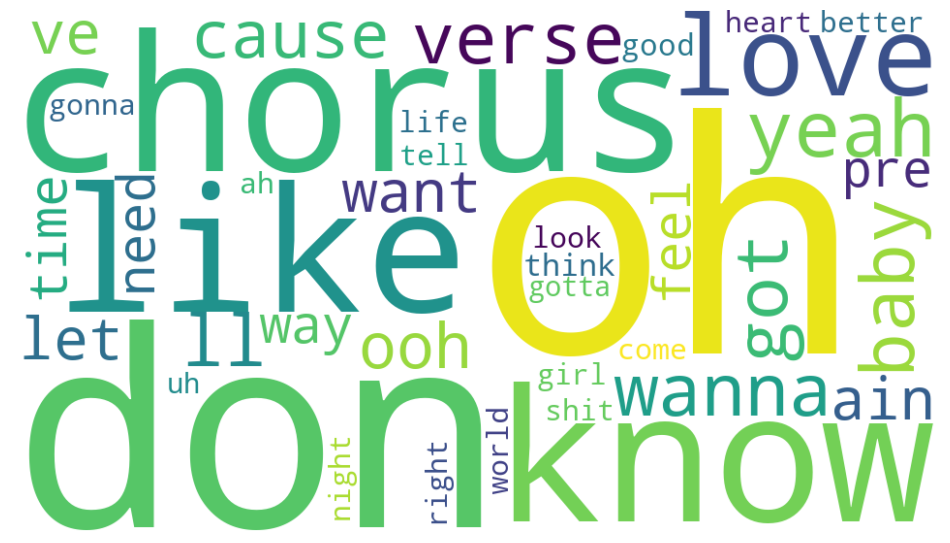

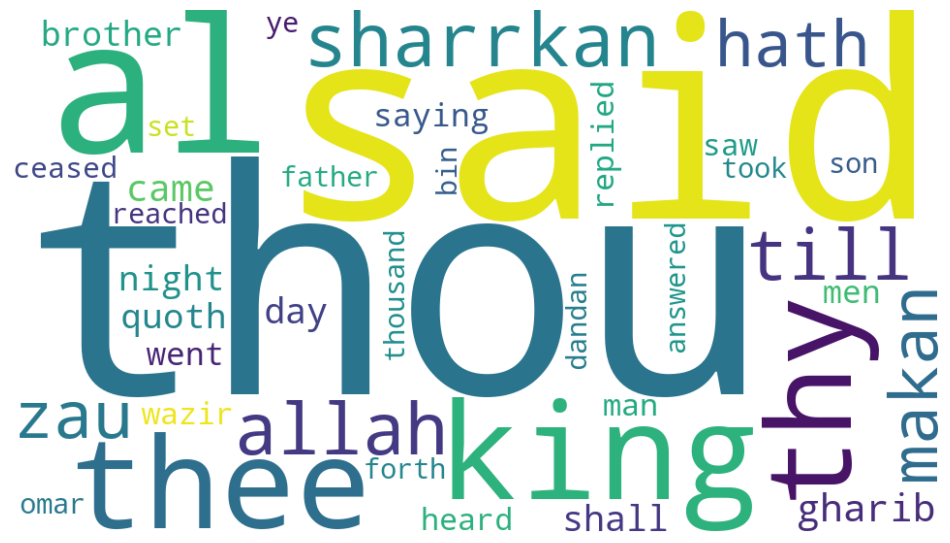

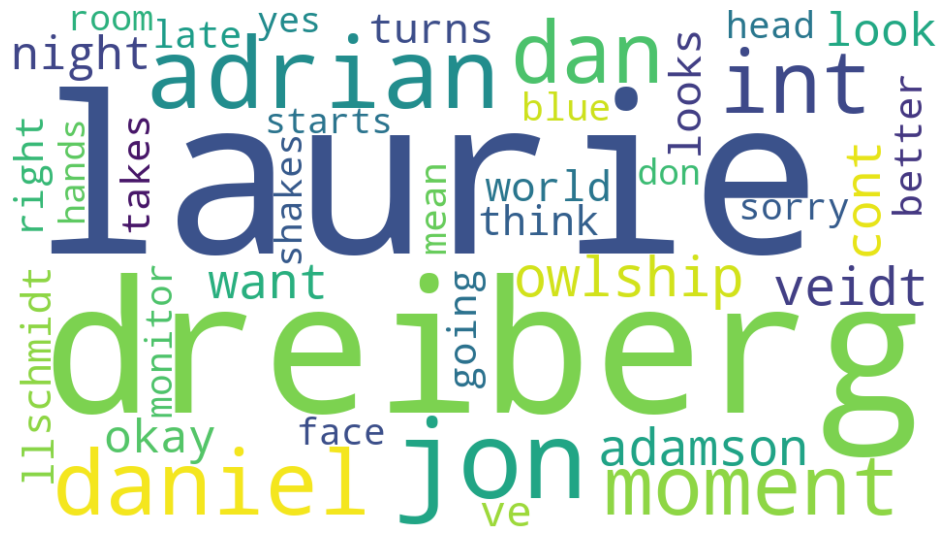

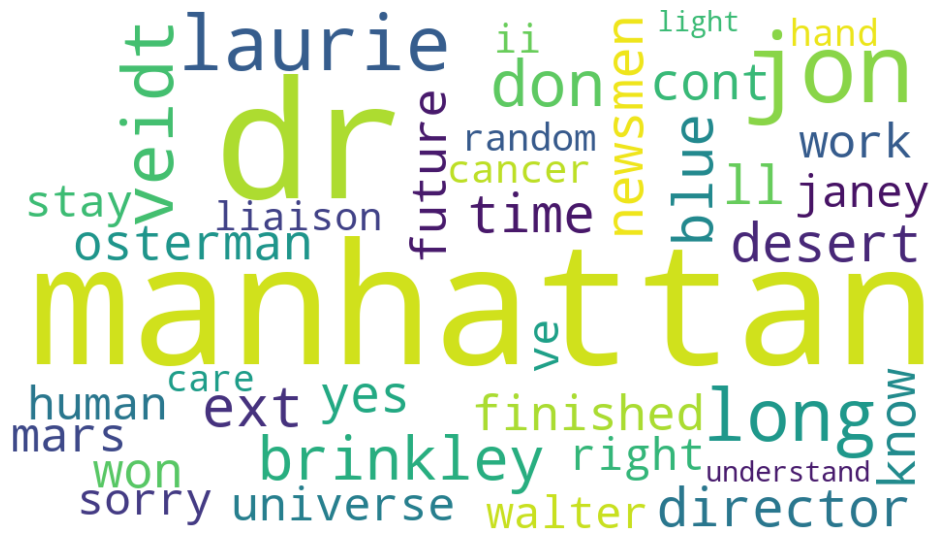

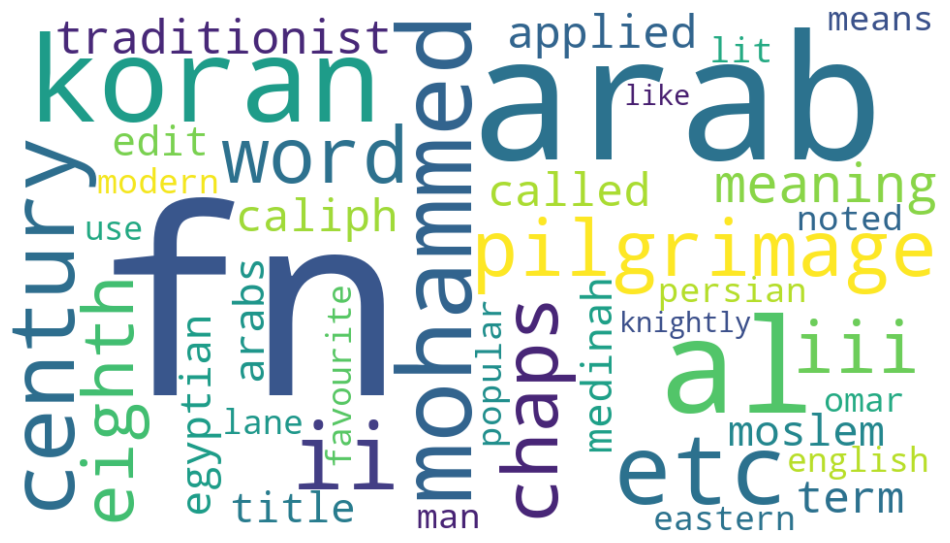

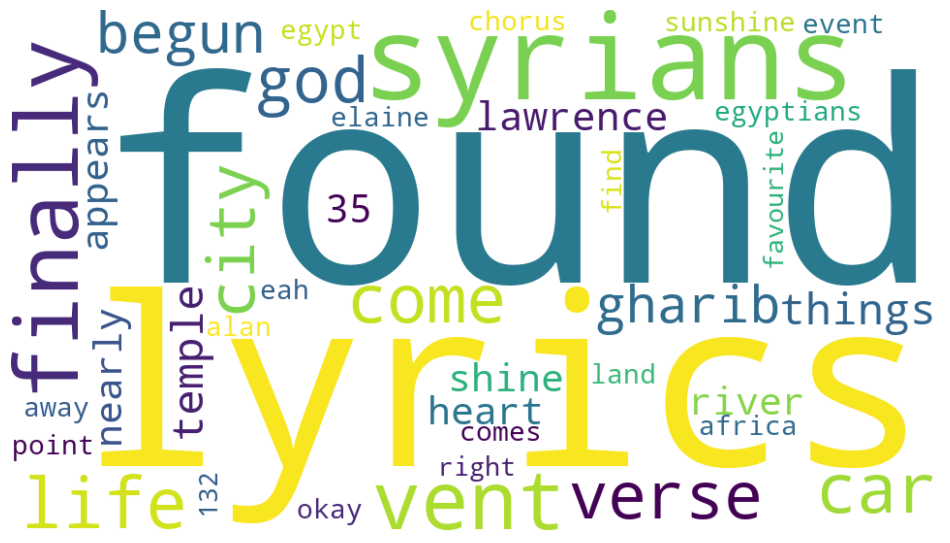

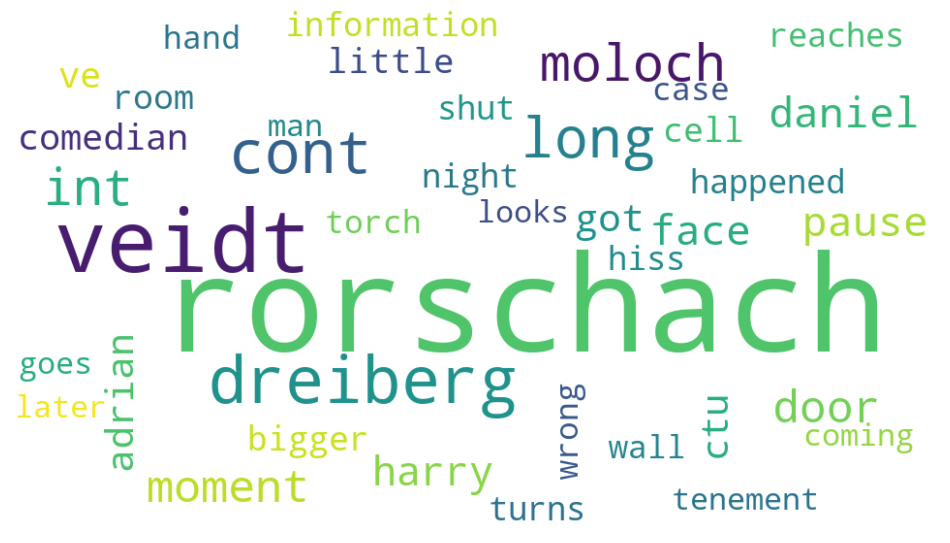

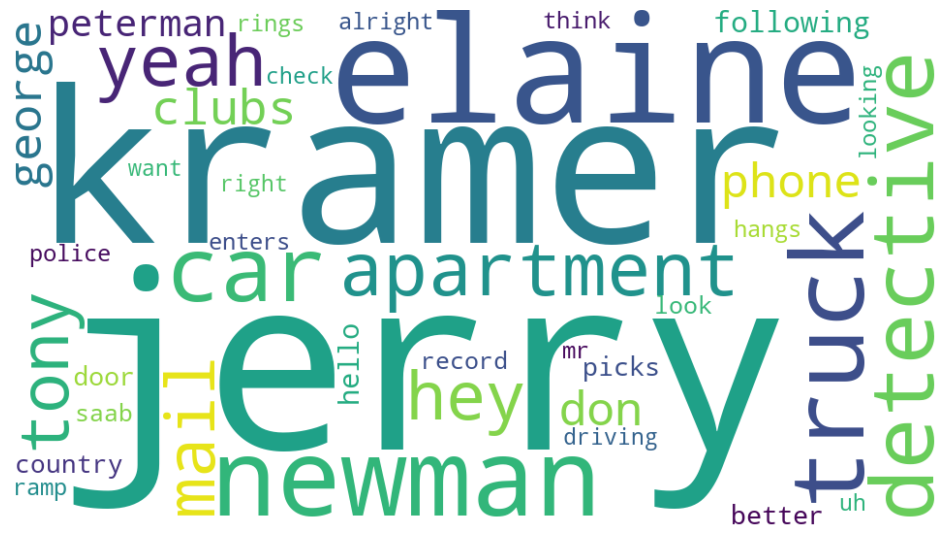

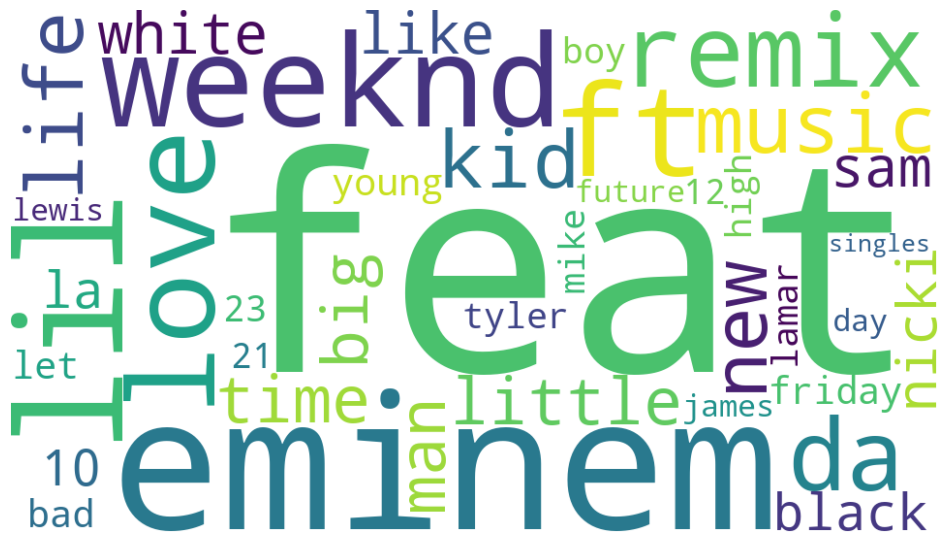

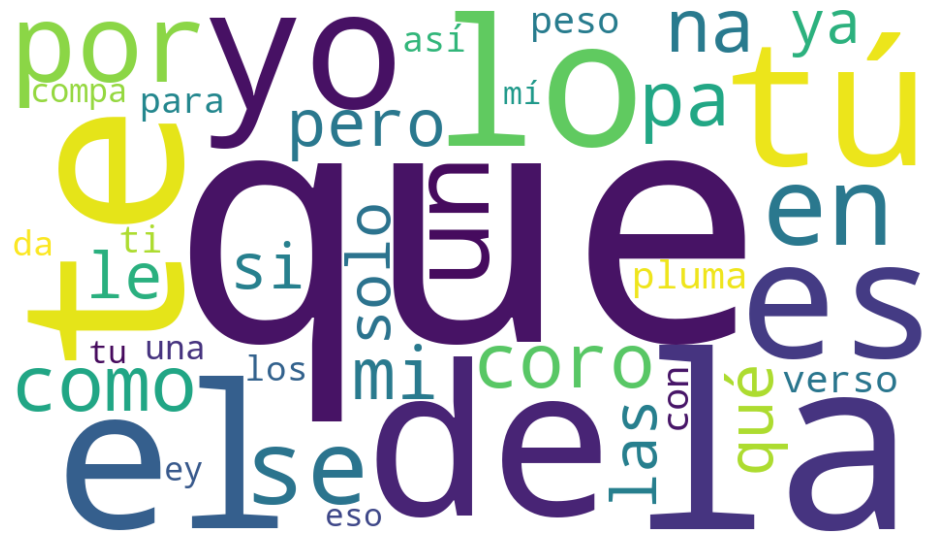

In [27]:
wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())

## lda wordcloud

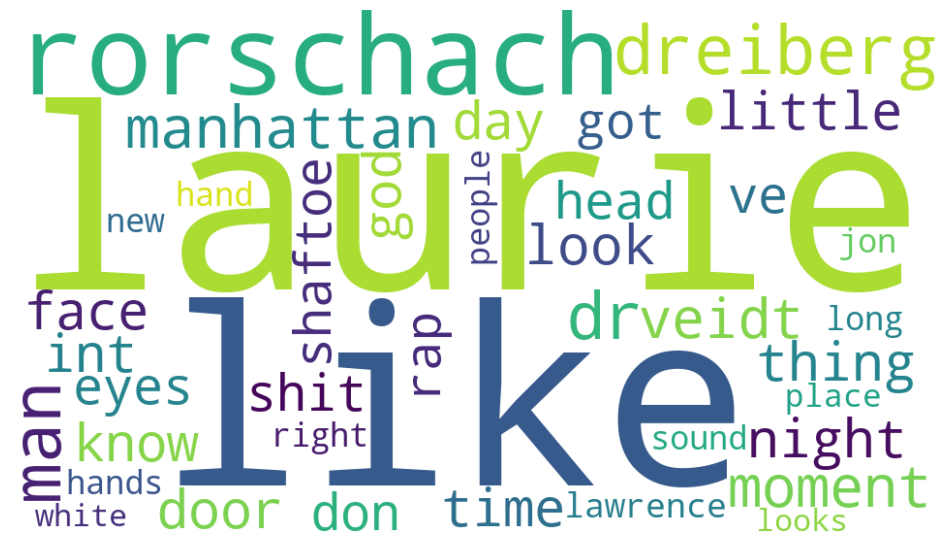

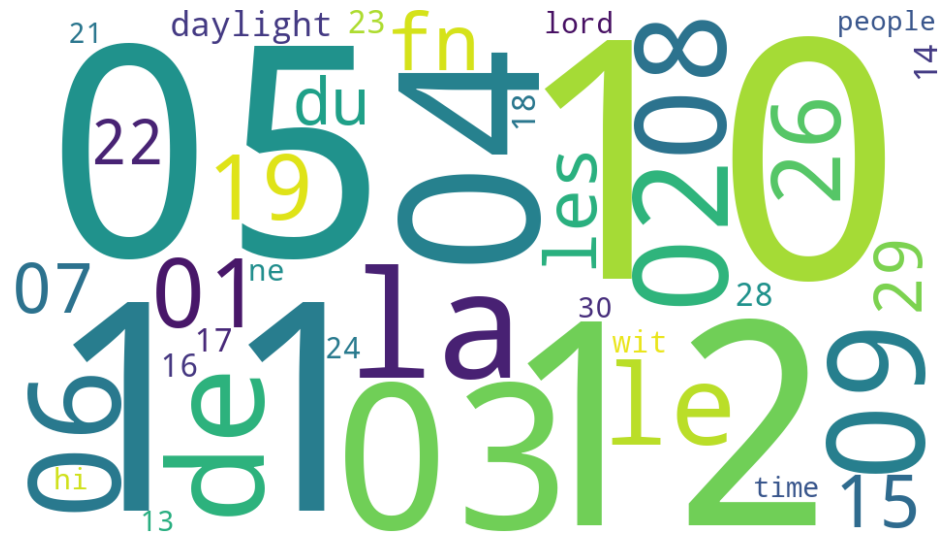

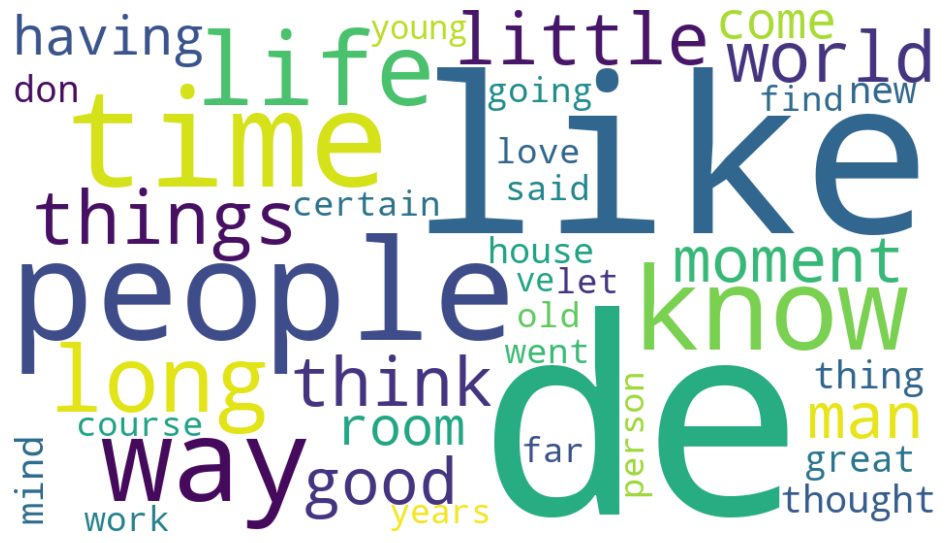

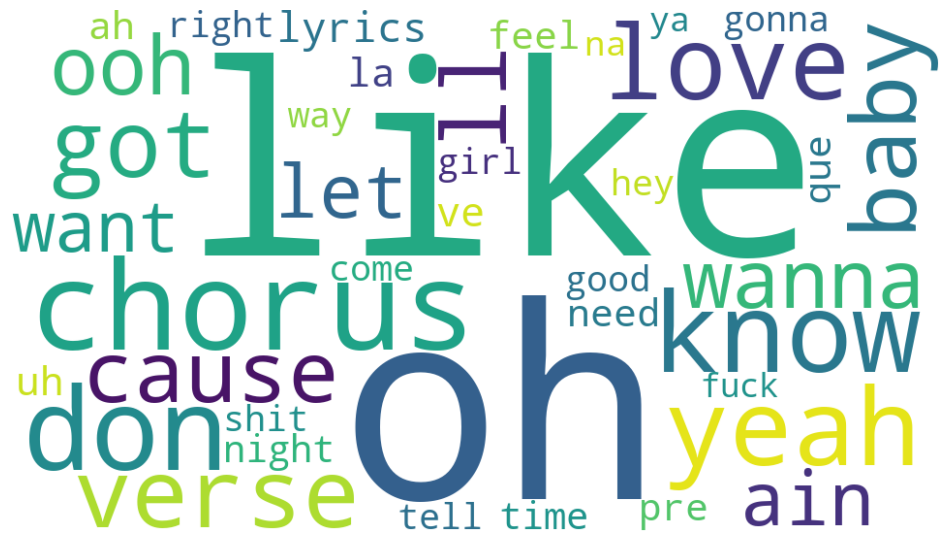

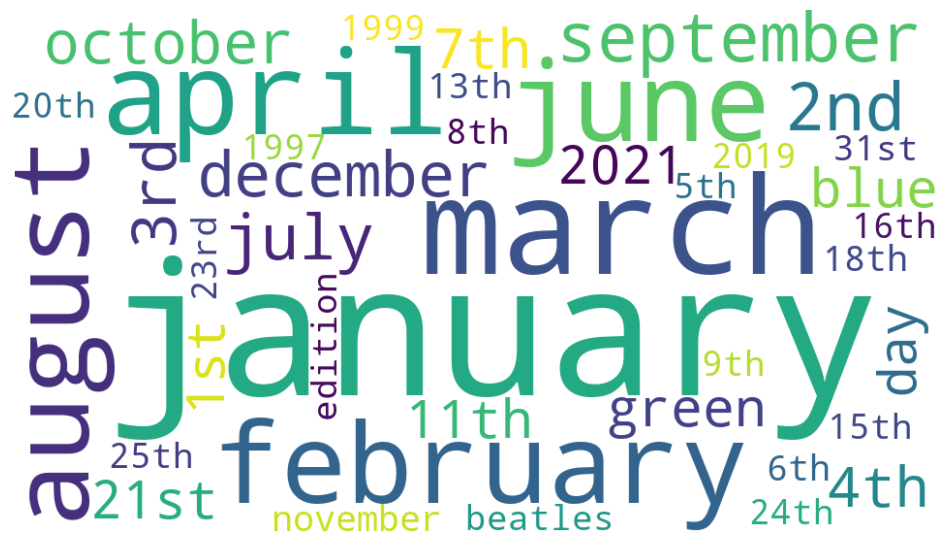

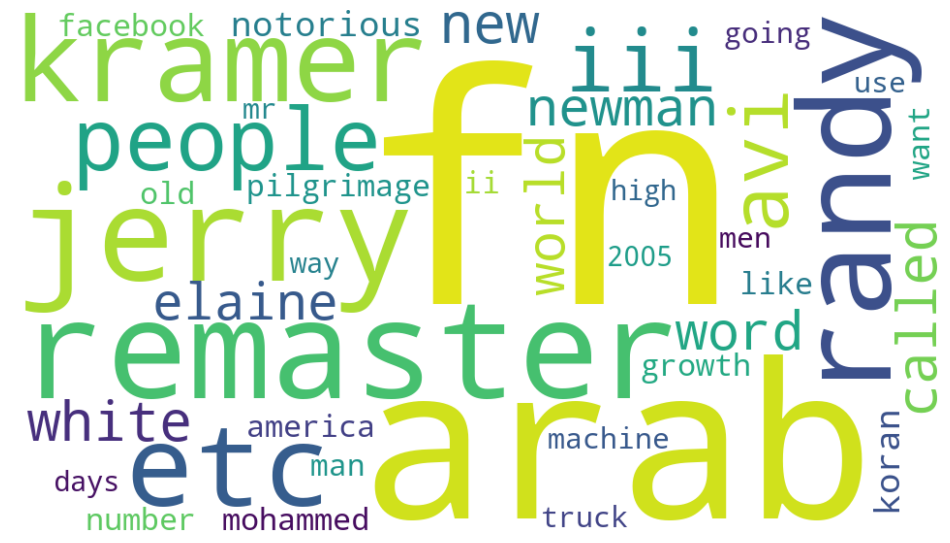

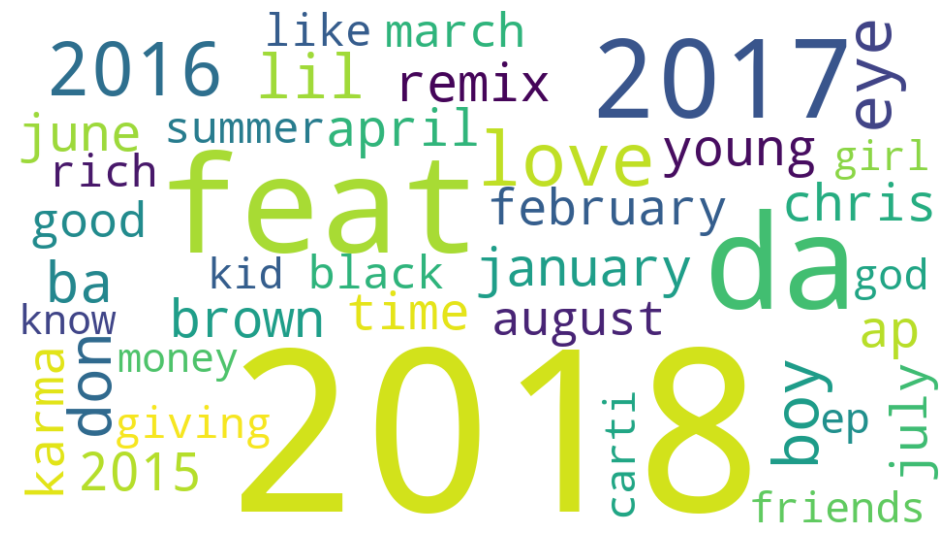

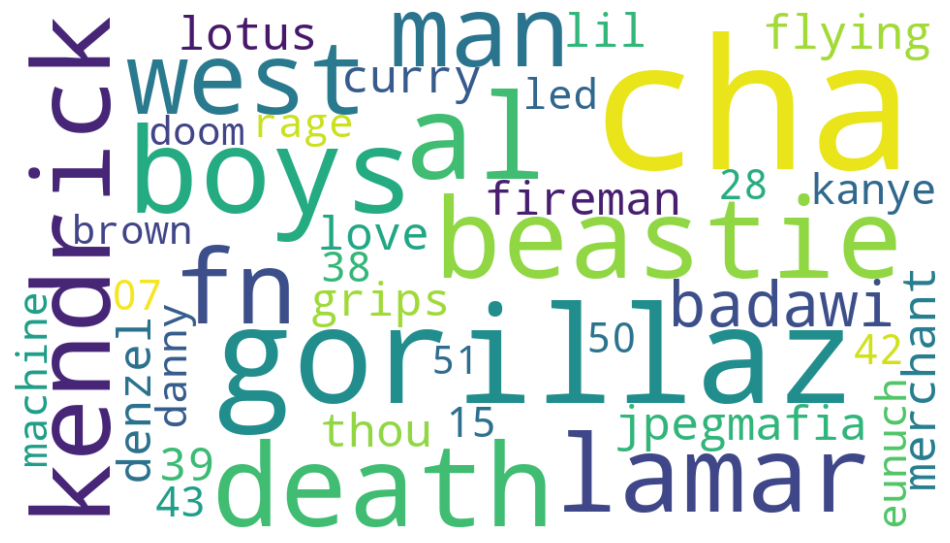

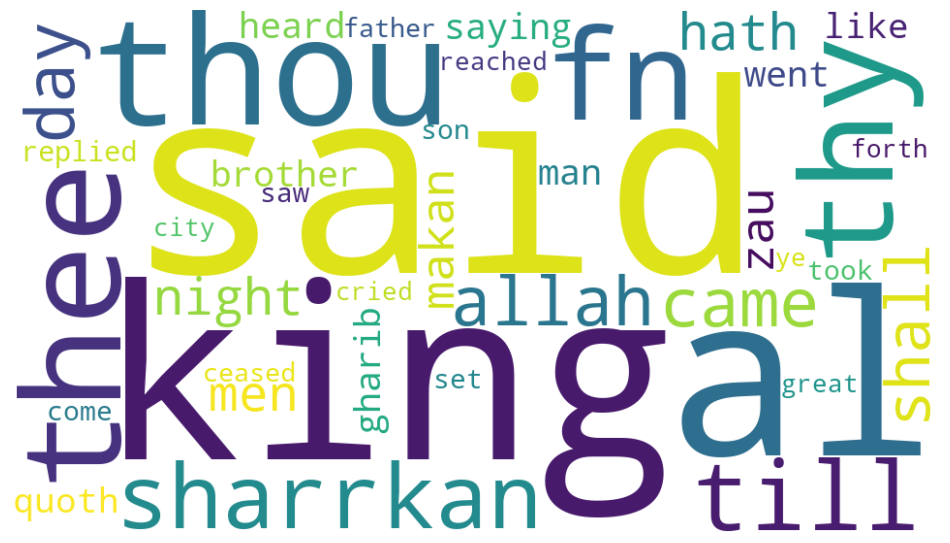

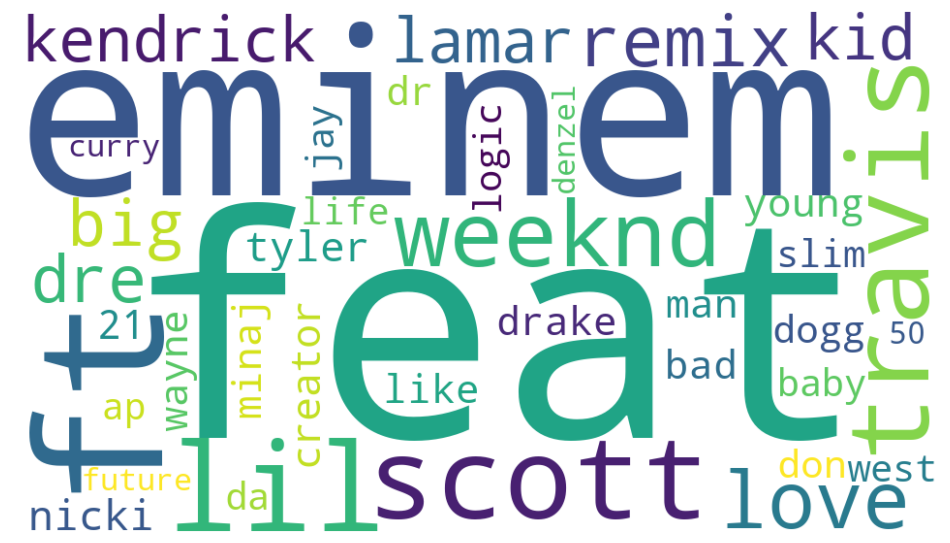

In [28]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names_out())

## Analysing by joining top 2 words

In [29]:
topic_names = []
voc = tfidf_para_vectorizer.get_feature_names_out()
for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

In [33]:
from tqdm.auto import tqdm
import numpy as np
year_data = []
for year in tqdm(np.unique(np.unique(paragraph_df["Popularity"]))):
    W_year = nmf_para_model.transform(tfidf_para_vectors[np.array(paragraph_df["Popularity"] == year)])
    year_data.append([year] + list(W_year.sum(axis=0)/W_year.sum()*100.0))

  0%|          | 0/84 [00:00<?, ?it/s]

<Axes: xlabel='year'>

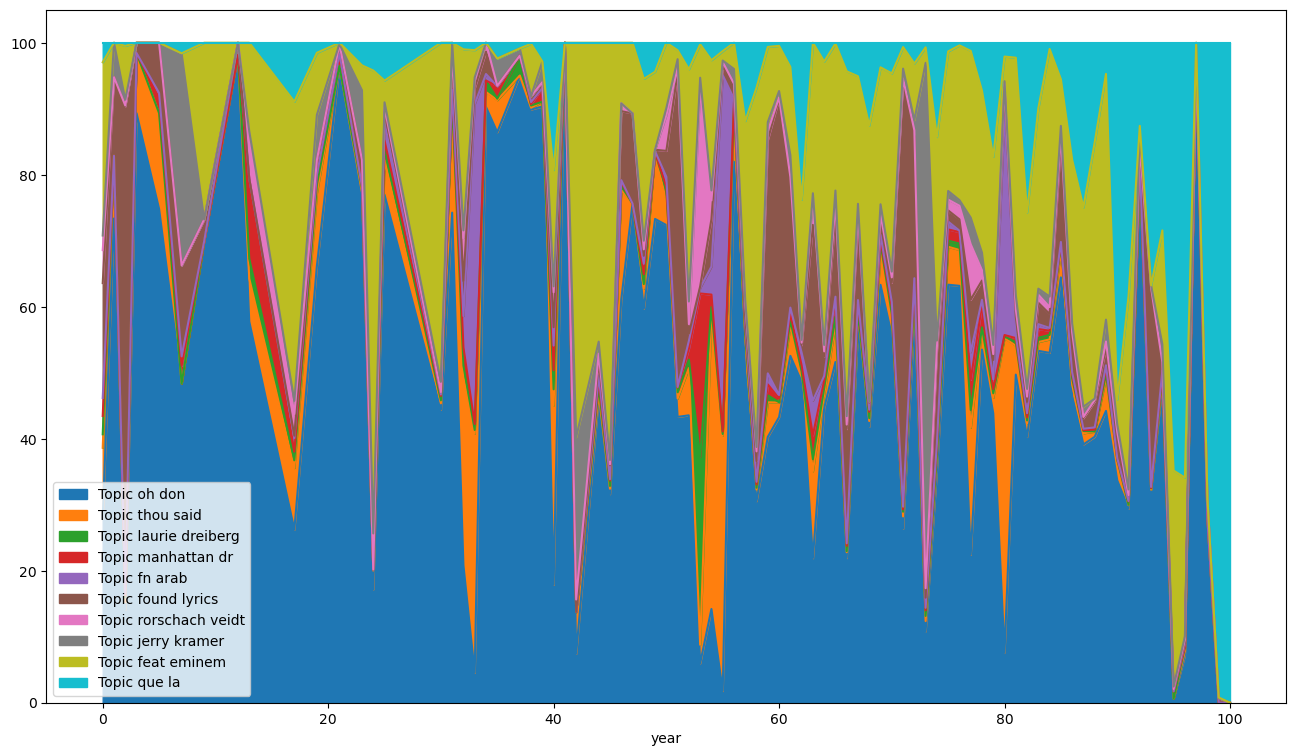

In [34]:
import matplotlib.pyplot as plt
df_year = pd.DataFrame(year_data, columns=["year"] + topic_names).set_index("year")
df_year.plot.area(figsize=(16,9))